# <center>WORKING 1:<font color=magenta>Feed-Forward Networks in Keras:</font> MNIST Example</center>

### Machine Learning LAB
### *ETSIT - UPM*
---
---

* ## This Notebook is a modified version of
[Introduction to Deep Learning with Keras and TensorFlow](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb)


**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

In [1]:
# This is to make plots visible in the Notebook
%matplotlib inline

* To help you understand the fundamentals of deep learning, this Notebook will walk through the basic steps of building a toy model for classifying handwritten numbers with accuracies surpassing 95%.

* In this notebook we will use a basic fully-connected neural network.

## The MNIST database

The MNIST database which contains 60,000 images for training and 10,000 test images.

> Note that differently from ML OSA use case, now we are not going to use any cross-validation strategy as the number of images for training and testing are much larger now.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

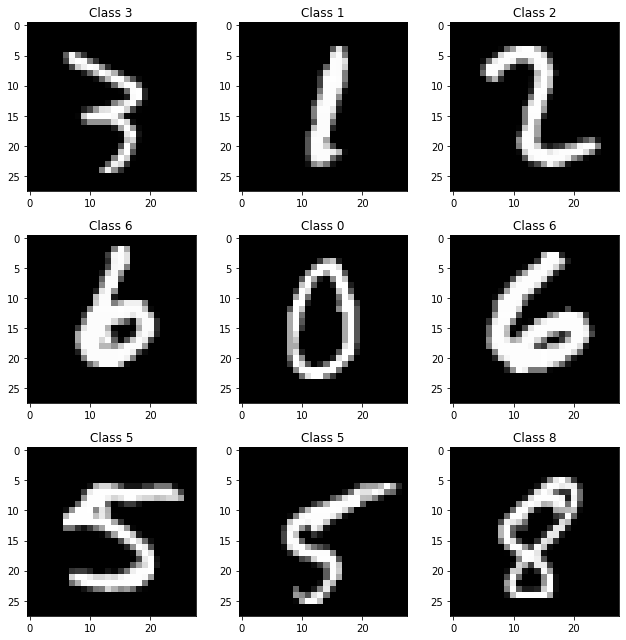

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0    0   15  133  232  255  187   52    0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0    0   19  200  254  251  233  243  237   51  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0    0   34  220  254  238  113   47   52  249  112  0  0  0  0  0  0  
0  0  0  0  0  0  0  0    0    0    0    0   30  222  254  254  254  254  246   24  244  112  0 

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.


# Image Classification using a Fully Connected Network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

## Formatting the input data layer

Note that for a Fully-Connected Network the input (i.e. each image) must be a vector!

* Then, instead of a 28 x 28 matrix, each image needs to be then <font color=red>reshaped (or flattened)</font> into a vector with dimension 784 (28x28). 

* We'll also <font color=red>normalize the inputs to be in the range [0-1]</font> rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [6]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [7]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
# see one example
num = 7
y_train[num]

3

In [9]:
Y_train[num]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

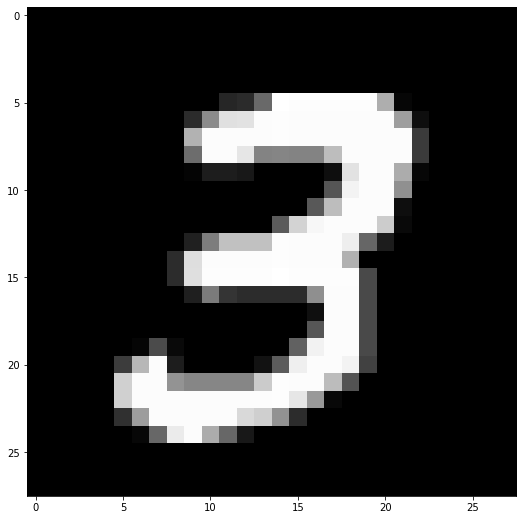

In [10]:
plt.imshow(X_train[num].reshape(28,28), cmap='gray', interpolation='none')

## Now we build a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

## Now we will design a Fully Connected Network using [Keras](https://keras.io/)

<img src="https://keras.io/img/logo.png" width="300" height="100" />


### The easiest way to design a Deep Learning Model in Keras is the [Sequential model](https://keras.io/guides/sequential_model/):
* you have just to define a plain stack of layers where each layer has exactly one input tensor and one output tensor.

#### You can learn Keras and follow many examplies in [Keras Web](https://keras.io)

In [11]:
# The Sequential model is a linear stack of layers.

#model = Sequential()

In [12]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

#model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [13]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

#model.add(Activation('relu'))

$$f(x) = max (0,x)$$
<img src = 'https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/relu.jpg?raw=1'>

In [14]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
#model.add(Dropout(0.2))

## Adding the second hidden layer

In [15]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

## The Final Output Layer

In [16]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
#model.add(Dense(10))

In [17]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

#model.add(Activation('softmax'))

In [18]:
##### IN A COMPACT WAY #####

#The Sequential model is a linear stack of layers.

#model = Sequential()
#model.add(Dense(512, input_shape=(784,)))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Dense(10))
#model.add(Activation('softmax'))

model = Sequential()
model.add(Dense(10, input_shape=(784,)))
model.add(Activation('softmax'))


In [19]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/gradient_descent.png?raw=1" >

<img src = "https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/learning_rate.png?raw=1" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/complicated_loss_function.png?raw=1' >

In [20]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# VISUALIZE Layers BEFORE any training

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


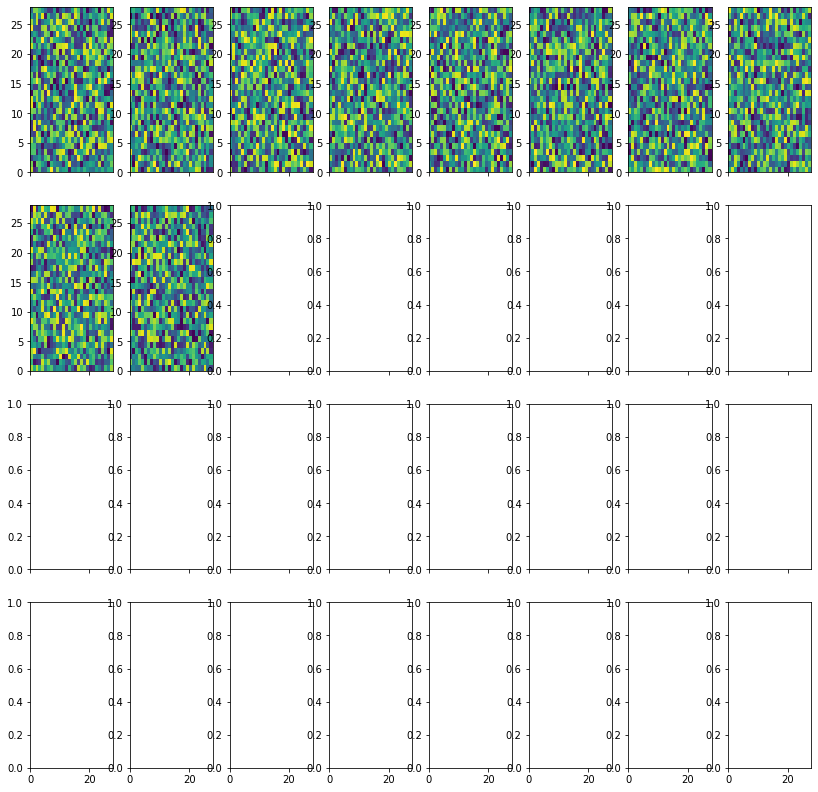

In [22]:
#Note that weights and biases are already numpy arrays.

weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]


print(bias)

# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, figsize=(14,14), sharex=True)
for i in range(10):
    plts[i//8, i%8].pcolor(weights[:,i].reshape([28,28]))


## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [23]:
hist = model.fit(X_train, Y_train,
          batch_size=128, epochs=2, validation_split=0.1,
          verbose=1)

Epoch 1/2
422/422 [==============================] - 2s 3ms/step - loss: 0.7101 - accuracy: 0.8278 - val_loss: 0.3531 - val_accuracy: 0.9102
Epoch 2/2
422/422 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8988 - val_loss: 0.2869 - val_accuracy: 0.9250


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

In [24]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Train Accuracy (blue):  0.9
Test_Accuracy (red):  0.93


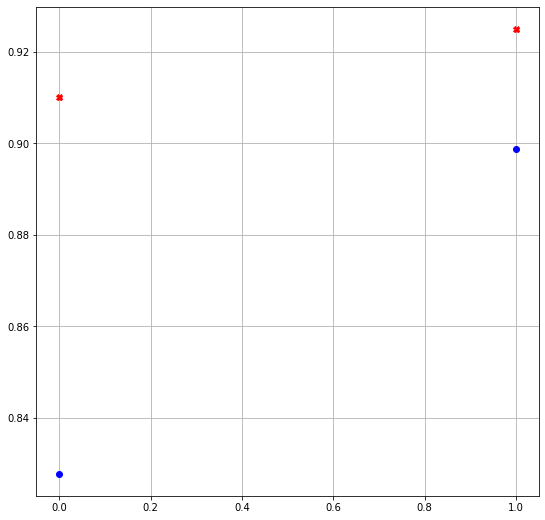

In [25]:
print('Train Accuracy (blue): ',np.round(hist.history['accuracy'][-1],2))
print('Test_Accuracy (red): ',np.round(hist.history['val_accuracy'][-1],2))

# Plot the accuracy curves
plt.plot(hist.history['accuracy'],'bo')
plt.plot(hist.history['val_accuracy'],'rX')
plt.grid()

## Evaluate Model's Accuracy on Test Data

In [26]:
score = model.evaluate(X_test, Y_test)
print('Test score (loss):', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3271 - accuracy: 0.9114
Test score (loss): 0.3270796537399292
Test accuracy: 0.9114000201225281


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [27]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict(X_test)

# Check which items we got right / wrong
correct_indices = np.where(np.argmax(predicted_classes,axis=1) == y_test)[0]

incorrect_indices = np.where(np.argmax(predicted_classes, axis=1) != y_test)[0]

313/313 [==============================] - 0s 1ms/step


Output posterior probabilities:  [4.9638063e-01 3.4472071e-06 4.4069838e-02 1.9245450e-05 6.3018464e-02
 7.1280256e-02 3.0196512e-01 2.9416912e-04 2.2408955e-02 5.5988343e-04]


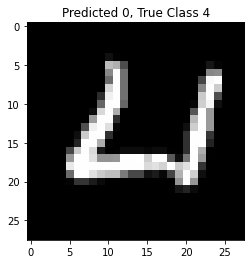

In [28]:
# Visualize some errors

error = 1
err_indx = incorrect_indices[error]

plt.figure(figsize=(4,4))

plt.imshow(X_test[err_indx].reshape(28,28), cmap='gray', interpolation='none')
plt.title("Predicted {}, True Class {}".format(np.argmax(predicted_classes[err_indx]), y_test[err_indx]))

print('Output posterior probabilities: ',predicted_classes[err_indx])

Output posterior probabilities:  [4.3176920e-03 2.0930331e-04 9.4538820e-01 7.7117365e-03 1.1112627e-07
 1.6484827e-02 2.3865640e-02 3.8888306e-08 2.0213239e-03 1.0156384e-06]


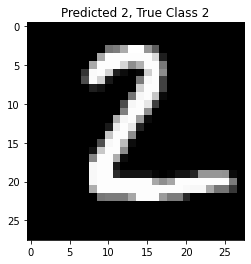

In [29]:
# Visualize some correct classifications

ok = 1
ok_indx = correct_indices[ok]

plt.figure(figsize=(4,4))

plt.imshow(X_test[ok_indx].reshape(28,28), cmap='gray', interpolation='none')
plt.title("Predicted {}, True Class {}".format(np.argmax(predicted_classes[ok_indx]), y_test[ok_indx]))

print('Output posterior probabilities: ',predicted_classes[ok_indx])


### Confusion Matrix

The confusion matrix gives a clear picture of our predictions.

In this Notebook we will use the [PyCM multi-class confusion matrix library written in Python](https://pypi.org/project/pycm/)

In [30]:
! pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from pycm import *

cm = ConfusionMatrix(actual_vector=y_test, predict_vector=np.argmax(predicted_classes,axis=1)) # Create CM From Data

In [32]:
cm.classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [33]:
cm.print_matrix()

Predict    0          1          2          3          4          5          6          7          8          9          
Actual
0          962        0          1          1          0          3          8          1          4          0          

1          0          1103       2          4          1          3          4          1          17         0          

2          13         6          899        19         13         2          13         16         47         4          

3          4          1          20         906        0          31         4          14         18         12         

4          2          1          6          0          893        0          14         1          10         55         

5          12         4          3          36         9          755        20         7          36         10         

6          15         3          7          0          10         10         909        1          3          0          

7         

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:128: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


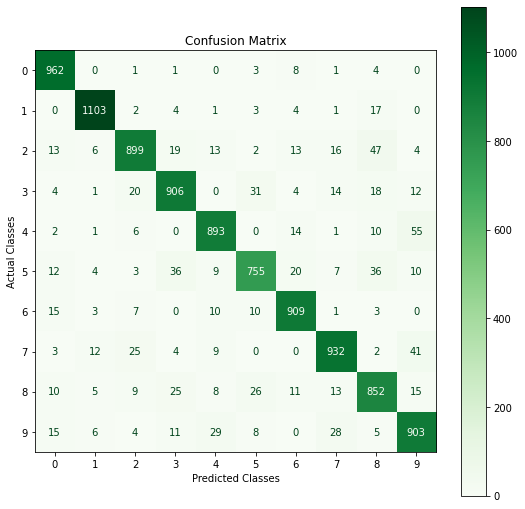

In [34]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

In [35]:
cm.print_normalized_matrix()

Predict       0             1             2             3             4             5             6             7             8             9             
Actual
0             0.98163       0.0           0.00102       0.00102       0.0           0.00306       0.00816       0.00102       0.00408       0.0           

1             0.0           0.97181       0.00176       0.00352       0.00088       0.00264       0.00352       0.00088       0.01498       0.0           

2             0.0126        0.00581       0.87112       0.01841       0.0126        0.00194       0.0126        0.0155        0.04554       0.00388       

3             0.00396       0.00099       0.0198        0.89703       0.0           0.03069       0.00396       0.01386       0.01782       0.01188       

4             0.00204       0.00102       0.00611       0.0           0.90937       0.0           0.01426       0.00102       0.01018       0.05601       

5             0.01345       0.00448       0.00336       0.

/usr/local/lib/python3.7/dist-packages/pycm/pycm_obj.py:161: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


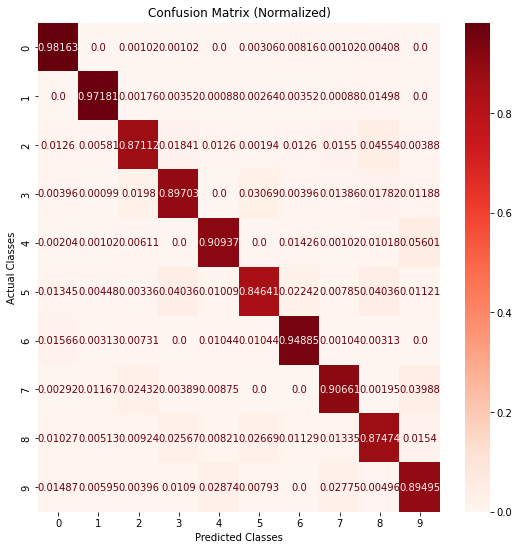

In [36]:
cm.plot(cmap=plt.cm.Reds,normalized=True,number_label=True, plot_lib="seaborn")

### Looking for "interpretability" ... exploring the information in Layer Weights Matrix


---

#### [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)


In [37]:
#This is the input tensor
model.layers[0].input

<KerasTensor: shape=(None, 784) dtype=float32 (created by layer 'dense_input')>

In [38]:
#Note that weights and biases are already numpy arrays.

weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

In [39]:
weights.shape

(784, 10)

In [46]:
print("The bias", bias)

The bias [-0.11936011  0.2390401  -0.05007839 -0.07415622  0.06431387  0.19215389
 -0.01476561  0.14348592 -0.28117186 -0.02619269]


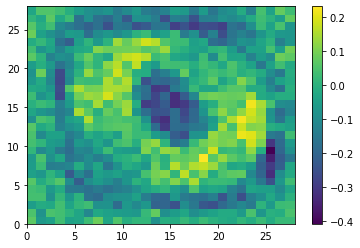

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.pcolor(weights[:,0].reshape([28,28]))

plt.colorbar()

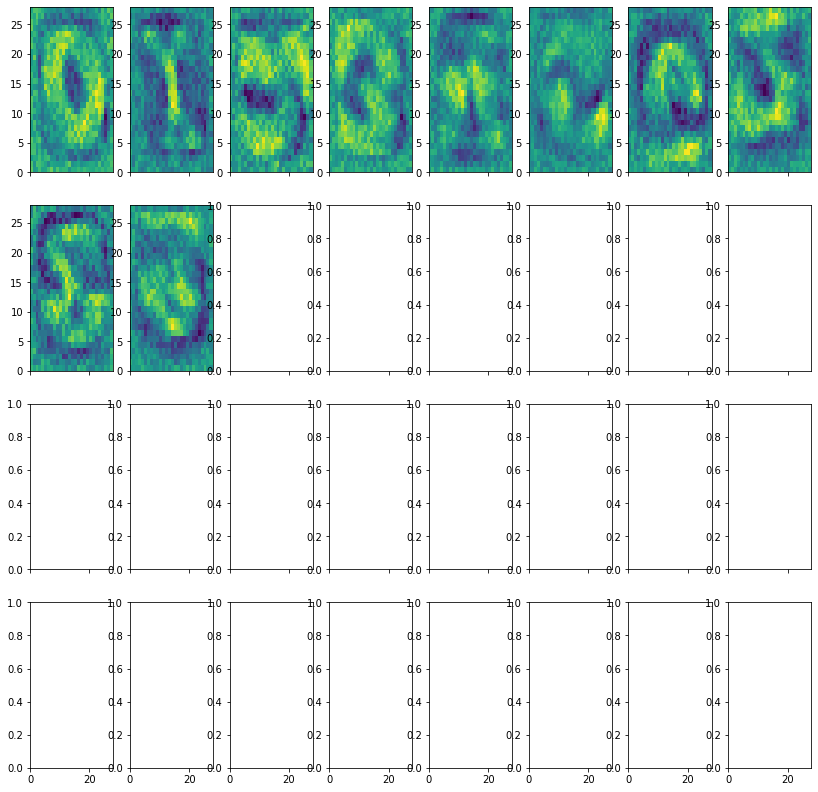

In [41]:
# Let's look at a subplot of some weights
f, plts = plt.subplots(4,8, figsize=(14,14), sharex=True)
for i in range(10):
    plts[i//8, i%8].pcolor(weights[:,i].reshape([28,28]))

In [42]:
# summarize feature map shapes
for i in range(len(model.layers)):
  layer = model.layers[i]
  print('Layer number: ',i)
  print(layer)


Layer number:  0
Layer number:  1


In [43]:
# redefine model to output right after the first hidden layer
from keras.models import Model

model_feature = Model(inputs=model.inputs, outputs=model.layers[1].output)

1/1 [==============================] - 0s 32ms/step


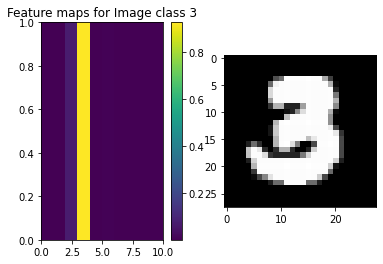

In [44]:
# choose any image to want by specifying the index
index =200
img = X_test[index]
img = np.expand_dims(img, axis=0) 

feature_map = model_feature.predict(img)

plt.subplot(121)
plt.pcolor(feature_map)
plt.title('Feature maps for Image class {}'.format(np.argmax(Y_test[index])))
plt.colorbar()

plt.subplot(122)
plt.imshow(img.reshape(28,28), cmap='gray', interpolation='none')

1/1 [==============================] - 0s 19ms/step


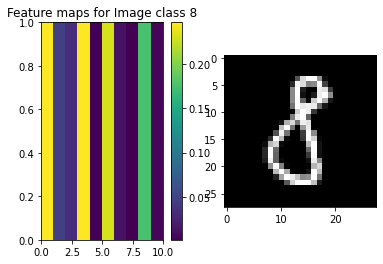

In [45]:
# choose any image to want by specifying the index
index =1200
img = X_test[index]
img = np.expand_dims(img, axis=0) 

feature_map = model_feature.predict(img)

plt.subplot(121)
plt.pcolor(feature_map)
plt.title('Feature maps for Image class {}'.format(np.argmax(Y_test[index])))
plt.colorbar()

plt.subplot(122)
plt.imshow(img.reshape(28,28), cmap='gray', interpolation='none')